In [7]:
using ResumableFunctions, StatsBase, Statistics
using FFTW, FITSIO, Intervals
using DocStringExtensions
using LinearAlgebra
using Random
using RecipesBase
using Test
using Distributions
using Printf
using ResumableFunctions, StatsBase, Statistics, DataFrames
using FFTW, NaNMath, FITSIO, Intervals
using ProgressBars: tqdm as show_progress
using DocStringExtensions
using LinearAlgebra
using Random

include("events.jl")
include("lightcurve.jl")
include("gti.jl")
include("fourier.jl")
function sum_if_not_none_or_initialize(A,B)
    if isnothing(A) 
        return deepcopy((B))
    end
    return A + B
end

function contiguous_regions(condition::AbstractVector{Bool})
    # Find the indicies of changes in "condition"
    d = diff(condition)
    idx = findall(!iszero, d)

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx .+= 1

    if condition[1]
        # If the start of condition is True prepend a 0
        pushfirst!(idx, 1)
    end

    if condition[end]
        # If the end of condition is True, append the length of the array
        push!(idx, condition.size+1)
    end

    # Reshape the result into two columns
    return reshape(idx,2,length(idx) ÷ 2)'
end
#UTIL function used in recpies
"""
    merge_overlapping_gtis(gtis::Matrix{Float64}) -> Matrix{Float64}

Merge overlapping or touching GTI intervals into continuous segments.

Takes a matrix of GTI intervals and combines any that overlap or touch into single
continuous intervals. The input GTIs are automatically sorted by start time.

# Arguments
- `gtis::Matrix{Float64}`: Matrix of GTI boundaries where each row is [start_time, stop_time]

# Returns
- `Matrix{Float64}`: Matrix with merged intervals, sorted by start time

# Examples
```julia
# Basic merging
gtis = [0.0 2.0; 1.0 3.0; 4.0 5.0]
result = merge_overlapping_gtis(gtis)
# Returns: [0.0 3.0; 4.0 5.0]

# Touching intervals
gtis = [0.0 1.0; 1.0 2.0; 2.0 3.0]
result = merge_overlapping_gtis(gtis)
# Returns: [0.0 3.0]
```
"""
function merge_overlapping_gtis(gtis::Matrix{Float64})
    if size(gtis, 1) <= 1
        return gtis
    end
    
    # Sort by start time
    sort_indices = sortperm(view(gtis, :, 1))
    sorted_gtis = gtis[sort_indices, :]
    
    # Pre-allocate merged array
    merged = Matrix{Float64}(undef, size(gtis, 1), 2)
    merged_count = 0
    
    current_start = sorted_gtis[1, 1]
    current_stop = sorted_gtis[1, 2]
    
    for i in 2:size(sorted_gtis, 1)
        start_time = sorted_gtis[i, 1]
        stop_time = sorted_gtis[i, 2]
        
        # Check if intervals overlap or touch (with small tolerance)
        if start_time <= current_stop + 1e-6
            current_stop = max(current_stop, stop_time)
        else
            # No overlap, add current interval to merged
            merged_count += 1
            merged[merged_count, 1] = current_start
            merged[merged_count, 2] = current_stop
            current_start = start_time
            current_stop = stop_time
        end
    end
    
    # Add the final interval
    merged_count += 1
    merged[merged_count, 1] = current_start
    merged[merged_count, 2] = current_stop
    
    return merged[1:merged_count, :]
end


merge_overlapping_gtis

avg_cs_from_events (generic function with 1 method)

In [9]:
# Your existing workflow with corrected function calls
events = readevents("ni1200120104_0mpu7_cl.evt", load_gti=true, sort=true)
lc = create_lightcurve(events, 0.01)
# Calculate PDS from events with 100-second segments
segment_size = 100.0  # seconds
dt = 0.01  # time resolution
pds_result = avg_pds_from_eventlist(events, segment_size, dt; 
                                   norm="frac", 
                                   use_common_mean=true, 
                                   silent=false)

Found GTI data: 16 intervals
GTI time range: 1.3253976595089495e8 to 1.3261337476368216e8


┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 0it 00:00 [-0s/it]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 1it 00:00 [InfGs/it]
┣╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 3it 00:01 [4it/s]
┣ ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 6it 00:01 [9it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱┫ 9it 00:01 [12it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 13it 00:01 [17it/s]
┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 16it 00:01 [20it/s]
┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 20it 00:01 [23it/s]
┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 24it 00:01 [26it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 25it 00:01 [19it/s]
┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 28it 00:01 [20it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 33it 00:01 [23it/s]
┣   ╱   ╱   ╱   ╱   ╱   ╱   

Row,freq,power,unnorm_power
,Float64,Float64,Float64
1,1.48566e-6,4.0828,2.07551e9
2,2.97133e-6,2.89899,1.47371e9
3,4.45699e-6,2.33859,1.18883e9
4,5.94265e-6,1.38807,7.05629e8
5,7.42832e-6,0.762773,3.87758e8
6,8.91398e-6,0.620154,3.15257e8
7,1.03996e-5,0.492801,2.50517e8
8,1.18853e-5,0.566369,2.87916e8
9,1.3371e-5,0.383711,1.95061e8


In [10]:
# Calculate PDS from light curve
pds_result = avg_pds_from_lightcurve(lc, 100.0;  # 100-second segments
                                    norm="frac", 
                                    use_common_mean=true, 
                                    silent=false)

0.0%┣                                                ┫ 0/1 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:01<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:01<Inf:Inf, InfGs/it]


Row,freq,power,unnorm_power
,Float64,Float64,Float64
1,1.36621e-9,48934.8,1.5087e14
2,2.73243e-9,2511.57,7.74336e12
3,4.09864e-9,9895.93,3.05099e13
4,5.46485e-9,2189.39,6.75007e12
5,6.83107e-9,4211.79,1.29853e13
6,8.19728e-9,2095.02,6.4591e12
7,9.56349e-9,2862.73,8.82603e12
8,1.09297e-8,3386.07,1.04395e13
9,1.22959e-8,3345.57,1.03146e13


In [11]:
# You would need two EventList objects
events2 = readevents("xmm_test.fits", load_gti=true, sort=true)
cs_result = avg_cs_from_eventlists(events, events2, segment_size, dt;
                                  norm="frac",
                                  use_common_mean=true,
                                  power_type="all")

Found GTI data: 1 intervals
GTI time range: -1.0 to 1025.0


┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 0it 00:00 [-0s/it]
┣╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 3it 00:00 [29it/s]
┣ ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱ ┫ 6it 00:00 [39it/s]
┣ ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱┫ 10it 00:00 [45it/s]
┣ ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱┫ 14it 00:00 [51it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 17it 00:00 [51it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 21it 00:00 [52it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 25it 00:00 [54it/s]
┣   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱  ┫ 28it 00:01 [54it/s]
┣  ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ┫ 33it 00:01 [56it/s]
┣╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱ ┫ 35it 00:01 [54it/s]
┣ ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱   ╱┫ 38it 00:01 [53it/s]
┣ ╱   ╱   ╱   ╱   ╱   ╱   ╱ 

In [12]:
# You would need two LightCurve objects
lc2 = create_lightcurve(events2, 0.01)
cs_result = avg_cs_from_lightcurves(lc, lc2, 100.0;
                                   norm="frac",
                                   use_common_mean=true,
                                   power_type="all")

┌ Warning: Light curves have different lengths, truncating to shorter one
└ @ Main In[8]:537
0.0%┣                                                ┫ 0/1 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]


Row,freq,power,unnorm_power
,Float64,Complex…,Complex…
1,9.7561e-8,-0.0206802+0.194362im,-5.06163e7+4.75716e8im
2,1.95122e-7,-0.133684+0.0031923im,-3.27203e8+7.81339e6im
3,2.92683e-7,0.140018-0.0243575im,3.42705e8-5.96169e7im
4,3.90244e-7,0.025027-0.0880923im,6.12554e7-2.15613e8im
5,4.87805e-7,0.0203273-0.0619181im,4.97525e7-1.51549e8im
6,5.85366e-7,-0.0724248+0.0934704im,-1.77265e8+2.28776e8im
7,6.82927e-7,0.0658721+0.0165446im,1.61227e8+4.04942e7im
8,7.80488e-7,-2.40791e-5+0.168758im,-58935.4+4.13048e8im
9,8.78049e-7,-0.00797045+0.00808994im,-1.95083e7+1.98008e7im


In [13]:
# Your existing code
events = readevents("ni1200120104_0mpu7_cl.evt", load_gti=true, sort=true)
lc = create_lightcurve(events, 0.01)

# Calculate PDS using the LightCurve approach
pds_result = avg_pds_from_lightcurve(lc, 100.0;  # 100-second segments
                                    norm="frac", 
                                    use_common_mean=true, 
                                    silent=false)

# Display results
if !isnothing(pds_result)
    println("PDS calculated successfully!")
    println("Number of frequency bins: ", length(pds_result.freq))
    println("Frequency range: ", minimum(pds_result.freq), " to ", maximum(pds_result.freq))

end

Found GTI data: 16 intervals
GTI time range: 1.3253976595089495e8 to 1.3261337476368216e8


0.0%┣                                                ┫ 0/1 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:02<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:02<Inf:Inf, InfGs/it]


PDS calculated successfully!
Number of frequency bins: 3659749
Frequency range: 1.3662135391761732e-9 to 0.004999998633786461


In [16]:
using Plots, Statistics
gr()



# Basic statistics
println("BASIC STATISTICS:")
println("Total frequency bins: ", length(pds_result.freq))
println("Frequency range: ", minimum(pds_result.freq), " to ", maximum(pds_result.freq), " Hz")
println("Power range: ", minimum(pds_result.power), " to ", maximum(pds_result.power))
println("Mean power: ", mean(pds_result.power))
println("Median power: ", median(pds_result.power))
println("Power standard deviation: ", std(pds_result.power))

# Create comprehensive plots


# Plot 1: Full PDS (log-log, subsampled)




BASIC STATISTICS:
Total frequency bins: 3659749
Frequency range: 1.3662135391761732e-9 to 0.004999998633786461 Hz
Power range: 4.360831904880767e-10 to 130716.20775831197
Mean power: 0.2963107671415322
Median power: 0.007024135976706224
Power standard deviation: 104.12612252131986


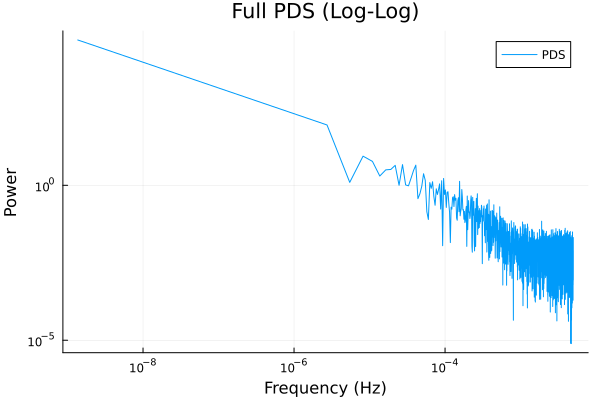

attempt to save state beyond implementation limit


In [22]:
subsample = 1:2000:length(pds_result.freq)
plot(pds_result.freq[subsample], pds_result.power[subsample],
      xscale=:log10, yscale=:log10,
      xlabel="Frequency (Hz)", ylabel="Power",
      title="Full PDS (Log-Log)", linewidth=1,
      label="PDS")




# # Plot 4: Power histogram
# plot!(p1[4], histogram(log10.(pds_result.power), bins=100,
#                       xlabel="log10(Power)", ylabel="Count",
#                       title="Power Distribution", alpha=0.7,
#                       label="Power Hist"))
# display(p1)

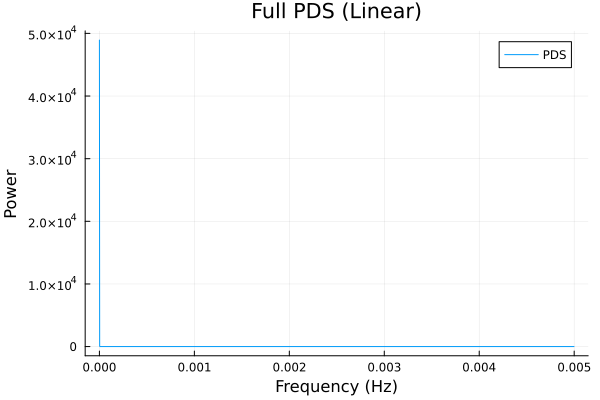

In [23]:
# Plot 2: Linear scale (subsampled)
plot( pds_result.freq[subsample], pds_result.power[subsample],
      xlabel="Frequency (Hz)", ylabel="Power",
      title="Full PDS (Linear)", linewidth=1,
      label="PDS")

In [ ]:
# Plot 3: High frequency region (zoom in)
high_freq_mask = pds_result.freq .> 1e-3
if any(high_freq_mask)
    high_indices = findall(high_freq_mask)[1:10:end]  # subsample
    plot( pds_result.freq[high_indices], pds_result.power[high_indices],
          xscale=:log10, yscale=:log10,
          xlabel="Frequency (Hz)", ylabel="Power",
          title="High Freq Region (>1e-3 Hz)", linewidth=1,
          label="High Freq")
end

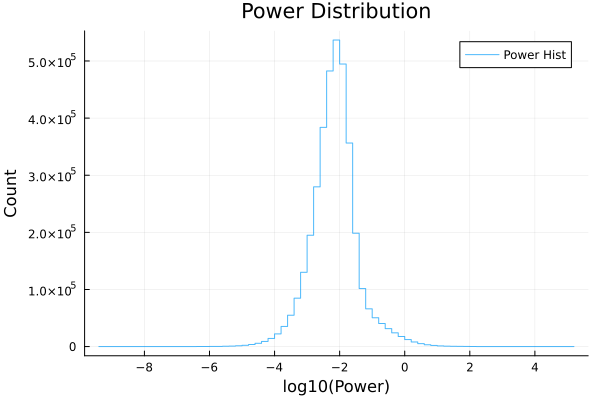

In [26]:
# Plot 4: Power histogram
plot(histogram(log10.(pds_result.power), bins=100,
                      xlabel="log10(Power)", ylabel="Count",
                      title="Power Distribution", alpha=0.7,
                      label="Power Hist"))